# Implémentation et expérimentation de l'algorithme de construction d'arbres monotones

In [80]:
import numpy as np
import pandas as pd
import math
import random
from utils import *
from functools import reduce
import matplotlib.pyplot as plt
import time
%matplotlib inline

### Création de la base jouet :

In [2]:
training_set = LabeledSet(2)

for i in range(0, 3):
    training_set.addExample([random.randint(0,2),random.randint(0,10)],1)
for i in range(0, 3):
    training_set.addExample([random.randint(3, 5), random.randint(0, 10)], 2)
for i in range(0, 4):
    training_set.addExample([random.randint(6, 10), random.randint(0,10)], 3)

In [3]:
df = pd.DataFrame(training_set.x, columns=['x1', 'x2'])
df['label'] = training_set.y
df

,x1,x2,label
0,1,3,1
1,2,1,1
2,1,1,1
3,3,0,2
4,4,10,2
5,5,1,2
6,6,8,3
7,7,10,3
8,6,2,3
9,8,3,3


### Ensembles dominants générés par un attribut/label

In [4]:
def dominant_sets_attribute(a_j, labeled_set):    
    '''
        a_j : index of attribute in labeled_set
        labeled_set : labeled set
        for each object w in labeled_set, return its dominant set generated by a_j  
    '''
    values = labeled_set.x.copy()
    ind = np.transpose(np.array([[i for i in range(labeled_set.size())]]))
    values = np.hstack((values, ind))
    
    dominant_sets = dict()
    for i in range(0, labeled_set.size()):
        v = labeled_set.getX(i)[a_j]
        dominant_sets[i] = set(values[values[:,a_j] >= v][:,labeled_set.getInputDimension()])
                
    return dominant_sets

def dominant_sets_label(labeled_set):
    '''
        labeled_set : labeled set
        for each object w in labeled_set, return its dominant set generated by its label  
    '''
    values = labeled_set.y.copy()
    ind = np.transpose(np.array([[i for i in range(labeled_set.size())]]))
    values = np.hstack((values, ind))
    
    dominant_sets = dict()
    
    for i in range(0, labeled_set.size()):
        v = labeled_set.getY(i)
        dominant_sets[i] = set(values[values[:,0] >= v][:,1])
                
    return dominant_sets
    
dsa_1 = dominant_sets_attribute(0, training_set)
dsa_2 = dominant_sets_attribute(1, training_set)
dsl = dominant_sets_label(training_set)

In [5]:
df_dsa1 = pd.DataFrame(list(dsa_1.items())).drop(0, axis=1)
df_dsa1.columns = ['dominant set generated by first attribute']
df_dsa1

,dominant set generated by first attribute
0,"{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}"
1,"{1, 3, 4, 5, 6, 7, 8, 9}"
2,"{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}"
3,"{3, 4, 5, 6, 7, 8, 9}"
4,"{4, 5, 6, 7, 8, 9}"
5,"{8, 9, 5, 6, 7}"
6,"{8, 9, 6, 7}"
7,"{9, 7}"
8,"{8, 9, 6, 7}"
9,{9}


In [6]:
df_dsa2 = pd.DataFrame(list(dsa_2.items())).drop(0, axis=1)
df_dsa2.columns = ['dominant set generated by second attribute']
df_dsa2

,dominant set generated by second attribute
0,"{0, 9, 4, 6, 7}"
1,"{0, 1, 2, 4, 5, 6, 7, 8, 9}"
2,"{0, 1, 2, 4, 5, 6, 7, 8, 9}"
3,"{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}"
4,"{4, 7}"
5,"{0, 1, 2, 4, 5, 6, 7, 8, 9}"
6,"{4, 6, 7}"
7,"{4, 7}"
8,"{0, 4, 6, 7, 8, 9}"
9,"{0, 9, 4, 6, 7}"


In [7]:
df_dsl = pd.DataFrame(list(dsl.items())).drop(0, axis=1)
df_dsl.columns = ['dominant set generated by label']
df_dsl

,dominant set generated by label
0,"{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}"
1,"{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}"
2,"{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}"
3,"{3, 4, 5, 6, 7, 8, 9}"
4,"{3, 4, 5, 6, 7, 8, 9}"
5,"{3, 4, 5, 6, 7, 8, 9}"
6,"{8, 9, 6, 7}"
7,"{8, 9, 6, 7}"
8,"{8, 9, 6, 7}"
9,"{8, 9, 6, 7}"


### Construction hiérarchique de mesures de discrimination

#### f-layer :

In [8]:
class F_layer:
    '''
        object-wise local monotonicity measure 
    '''

    def value(self, w_i, labeled_set, esa, esl):
        raise NotImplementedError
        
    def equal_sets_attribute(self, labeled_set, a_j):    
        '''
            a_j : index of attribute in labeled_set
            labeled_set : labeled set
            for each object w in labeled_set, return its equal set generated by a_j  
        '''
        values = labeled_set.x.copy()
        ind = np.transpose(np.array([[i for i in range(labeled_set.size())]]))
        values = np.hstack((values, ind))

        dominant_sets = dict()
        for i in range(0, labeled_set.size()):
            v = labeled_set.getX(i)[a_j]
            dominant_sets[i] = set(values[values[:,a_j] == v][:,labeled_set.getInputDimension()])

        return dominant_sets
    
    def equal_sets_label(self, labeled_set):    
        '''
            labeled_set : labeled set
            for each object w in labeled_set, return its dominant set generated by its label  
        '''
        values = labeled_set.y.copy()
        ind = np.transpose(np.array([[i for i in range(labeled_set.size())]]))
        values = np.hstack((values, ind))

        dominant_sets = dict()

        for i in range(0, labeled_set.size()):
            v = labeled_set.getY(i)
            dominant_sets[i] = set(values[values[:,0] == v][:,1])

        return dominant_sets
    
    def dominant_sets_attribute(self, labeled_set, a_j):    
        '''
            a_j : index of attribute in labeled_set
            labeled_set : labeled set
            for each object w in labeled_set, return its dominant set generated by a_j  
        '''
        values = labeled_set.x.copy()
        ind = np.transpose(np.array([[i for i in range(labeled_set.size())]]))
        values = np.hstack((values, ind))

        dominant_sets = dict()
        for i in range(0, labeled_set.size()):
            v = labeled_set.getX(i)[a_j]
            dominant_sets[i] = set(values[values[:,a_j] >= v][:,labeled_set.getInputDimension()])

        return dominant_sets

    def dominant_sets_label(self, labeled_set):
        '''
            labeled_set : labeled set
            for each object w in labeled_set, return its dominant set generated by its label  
        '''
        values = labeled_set.y.copy()
        ind = np.transpose(np.array([[i for i in range(labeled_set.size())]]))
        values = np.hstack((values, ind))

        dominant_sets = dict()

        for i in range(0, labeled_set.size()):
            v = labeled_set.getY(i)
            dominant_sets[i] = set(values[values[:,0] >= v][:,1])

        return dominant_sets

In [9]:
class Ds(F_layer):
    def value(self, w_i, labeled_set, esa, esl):
        '''
            labeled_set : labeled set
            w_i : index of object in labeled_set
            return ds value of w_i, a_j
        '''
        esa_i = esa[w_i]
        esl_i = esl[w_i]
        intersection = esa_i.intersection(esl_i)
        
        return len(intersection) * 1.0 / len(esa_i)

In [10]:
ds_2 = Ds()
ds_2_values = []
esa = ds_2.equal_sets_attribute(training_set, 1)
esl = ds_2.equal_sets_label(training_set)
for i in range(0, 10):
    ds_2_values.append(ds_2.value(i, training_set, esa, esl))
pd.DataFrame(ds_2_values, columns=['ds generated by second attribute'])

,ds generated by second attribute
0,0.500000
1,0.666667
2,0.666667
3,1.000000
4,0.500000
5,0.333333
6,1.000000
7,0.500000
8,1.000000
9,0.500000


$dsr(\omega_i)$ :

In [11]:
class Dsr(F_layer):
    
    def value(self, w_i, labeled_set, dsa, dsl):
        '''
            labeled_set : labeled set
            w_i : index of object in labeled_set
            return dsr value of w_i, a_j
        '''
        dsa_i = dsa[w_i]
        dsl_i = dsl[w_i]
        intersection = dsa_i.intersection(dsl_i)
        
        return len(intersection) * 1.0 / len(dsa_i)

In [12]:
dsr_1 = Dsr()
dsr_1_values = []
dsa = dsr_1.dominant_sets_attribute(training_set, 0)
dsl = dsr_1.dominant_sets_label(training_set)

for i in range(0, 10):
    dsr_1_values.append(dsr_1.value(i, training_set, dsa, dsl))
pd.DataFrame(dsr_1_values, columns=['dsr generated by first attribute'])

,dsr generated by first attribute
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
5,1.0
6,1.0
7,1.0
8,1.0
9,1.0


In [13]:
dsr_2 = Dsr()
dsr_2_values = []
dsa = dsr_2.dominant_sets_attribute(training_set, 1)
dsl = dsr_2.dominant_sets_label(training_set)

for i in range(0, 10):
    dsr_2_values.append(dsr_2.value(i, training_set, dsa, dsl))
pd.DataFrame(dsr_2_values, columns=['dsr generated by second attribute'])

,dsr generated by second attribute
0,1.000000
1,1.000000
2,1.000000
3,0.700000
4,1.000000
5,0.666667
6,0.666667
7,0.500000
8,0.666667
9,0.600000


In [14]:
class Minds(F_layer):
    
    def value(self, w_i, labeled_set, esa, esl):
        '''
            labeled_set : labeled set
            w_i : index of object in labeled_set
            return minds value of w_i, a_j
        '''
        n = labeled_set.size()
        intersections_lengths = []
        equal_set = esa[w_i]
        
        for w_h in equal_set:
            intersections_lengths.append(len(esa[w_h].intersection(esl[w_h])))
    
        return min(intersections_lengths) * 1.0 / len(equal_set)    

In [15]:
minds_2 = Minds()
minds_2_values = []
esa = minds_2.equal_sets_attribute(training_set, 1)
esl = minds_2.equal_sets_label(training_set)

for i in range(0, 10):
    minds_2_values.append(minds_2.value(i,training_set, esa, esl))
pd.DataFrame(minds_2_values, columns=['minds generated by second attribute'])

,minds generated by second attribute
0,0.500000
1,0.333333
2,0.333333
3,1.000000
4,0.500000
5,0.333333
6,1.000000
7,0.500000
8,1.000000
9,0.500000


$mindsr(\omega_i)$

In [16]:
class Mindsr(F_layer):  
    def value(self, w_i, labeled_set, dsa, dsl):
        '''
            labeled_set : labeled set
            w_i : index of object in labeled_set
            return mindsr value of w_i, a_j
        '''
        n = labeled_set.size()
        intersections_lengths = []
        dominant_set = dsa[w_i]
        
        for w_h in dominant_set:
            intersections_lengths.append(len(dsa[w_h].intersection(dsl[w_h])))
    
        return min(intersections_lengths) * 1.0 / len(dominant_set)    

In [17]:
mindsr_1 = Mindsr()
mindsr_1_values = []
dsa = mindsr_1.dominant_sets_attribute(training_set, 0)
dsl = mindsr_1.dominant_sets_label(training_set)

for i in range(0, 10):
    mindsr_1_values.append(mindsr_1.value(i,training_set, dsa, dsl))
pd.DataFrame(mindsr_1_values, columns=['mindsr generated by first attribute'])

,mindsr generated by first attribute
0,0.100000
1,0.125000
2,0.100000
3,0.142857
4,0.166667
5,0.200000
6,0.250000
7,0.500000
8,0.250000
9,1.000000


$maxdsr(\omega_i)$

In [18]:
class Maxdsr(F_layer):
    def value(self, w_i, labeled_set, dsa, dsl):
        '''
            w_i : index of object in labeled_set
            return maxdsr value of w_i, a_j
        '''
        n = labeled_set.size()
        intersections_lengths = []

        dominant_set = dsa[w_i]
        
        for w_h in dominant_set:
            intersections_lengths.append(len(dsa[w_h].intersection(dsl[w_h])))
    
    
        return max(intersections_lengths) * 1.0 / len(dominant_set)    

In [19]:
class Maxds(F_layer):

    def value(self, w_i, labeled_set, esa, esl):
        '''
            w_i : index of object in labeled_set
            return maxds value of w_i, a_j
        '''
        n = labeled_set.size()
        intersections_lengths = []

        equal_set = esa[w_i]
        
        for w_h in equal_set:
            intersections_lengths.append(len(esa[w_h].intersection(esl[w_h])))
    
    
        return max(intersections_lengths) * 1.0 / len(equal_set)    

$avgdsr(\omega_i)$

In [20]:
class Avgdsr(F_layer):
    def value(self, w_i, labeled_set, dsa, dsl):
        '''
            labeled_set : labeled set
            w_i : index of object in labeled_set
            return avgdsr value of w_i, a_j
        '''
        n = labeled_set.size()
        intersections_lengths = []

        dominant_set = dsa[w_i]
        
        for w_h in dominant_set:
            intersections_lengths.append(len(dsa[w_h].intersection(dsl[w_h])))
            
        return (1.0/len(dominant_set) * np.sum(intersections_lengths)) * 1.0 / len(dominant_set)    

In [21]:
class Avgds(F_layer):
    def value(self, w_i, labeled_set, esa, esl):
        '''
            labeled_set : labeled set
            w_i : index of object in labeled_set
            return avgds value of w_i, a_j
        '''
        n = labeled_set.size()
        intersections_lengths = []

        equal_set = esa[w_i]
        
        for w_h in equal_set:
            intersections_lengths.append(len(esa[w_h].intersection(esl[w_h])))
            
        return (1.0/len(equal_set) * np.sum(intersections_lengths)) * 1.0 / len(equal_set)    

In [22]:
avgdsr_2 = Avgdsr()
avgdsr_2_values = []
dsa = avgdsr_2.dominant_sets_attribute(training_set, 1)
dsl = avgdsr_2.dominant_sets_label(training_set)

for i in range(0, 10):
    avgdsr_2_values.append(avgdsr_2.value(i, training_set, dsa, dsl))
pd.DataFrame(avgdsr_2_values, columns=['avgdsr generated by second attribute'])

,avgdsr generated by second attribute
0,0.520000
1,0.506173
2,0.506173
3,0.480000
4,0.750000
5,0.506173
6,0.555556
7,0.750000
8,0.472222
9,0.520000


In [23]:
avgds_2 = Avgds()
avgds_2_values = []

esa = avgds_2.equal_sets_attribute(training_set, 1)
esl = avgds_2.equal_sets_label(training_set)

for i in range(0, 10):
    avgds_2_values.append(avgds_2.value(i, training_set, esa, esl))
pd.DataFrame(avgds_2_values, columns=['avgds generated by second attribute'])

,avgds generated by second attribute
0,0.500000
1,0.555556
2,0.555556
3,1.000000
4,0.500000
5,0.555556
6,1.000000
7,0.500000
8,1.000000
9,0.500000


#### g-layer :

In [24]:
class G_layer:
    '''
        object-wise local non-monotonicity measure
    '''
        
    def value(self, f_value):
        raise NotImplementedError

In [25]:
class Log(G_layer):    
    def value(self, f_value):
        '''
            f_value : value computed by f_layer
            return -log_2(f_value)
        '''
        return -log(f_value, 2) 

In [26]:
class One_minus(G_layer):    
    def value(self, f_value):
        '''
            f_value : value computed by f_layer
            return 1 - f_value
        '''
        return 1 - f_value

#### h-layer :

In [27]:
class H_layer:
    '''
        aggregated local non-monotonicity measure
    '''
        
    def value(self, g_values, labeled_set):
        raise NotImplementedError

In [28]:
class Sum(H_layer):    
    def value(self, g_values, labeled_set):
        '''
            return (1/labeled_set.size()) * sum(g_values)
        '''
        return (1.0/labeled_set.size()) * np.sum(g_values)

#### Rank Shannon discrimination measure $H^*_s(\lambda | a_j)$ :

In [29]:
def rsdm(f_layer, labeled_set, dsa, dsl):
    '''
        f_layer : object-wise local monotonicity measure 
        labeled_set : labeled set
        return the rank shannon discrimination measure generated by attribute a_j
    '''
    H = 0
    n = labeled_set.size()
    for i in range(0, n):
        H += -log(f_layer.value(i, labeled_set, dsa, dsl), 2)
    return (1.0/n)*H

In [30]:
dsr_shannon = Dsr()
dsa_1 = dsr_shannon.dominant_sets_attribute(training_set, 0)
dsl = dsr_shannon.dominant_sets_label(training_set)
dsa_2 = dsr_shannon.dominant_sets_attribute(training_set, 1)
print("Rank Shannon discrimination measure generated by first attribute : ", rsdm(dsr_shannon, training_set, dsa_1, dsl))
print("Rank shannon discrimination measure generated by second attribute : ", rsdm(dsr_shannon, training_set, dsa_2, dsl))

Rank Shannon discrimination measure generated by first attribute :  0.0
Rank shannon discrimination measure generated by second attribute :  0.4006426269159434


#### Rank Gini discrimination measure $H^*_G(\lambda | a_j)$

In [31]:
def rgdm(f_layer, labeled_set, dsa, dsl):
    '''
        f_layer : object-wise local monotonicity measure 
        labeled_set : labeled set
        return the rank gini discrimination measure generated by attribute a_j
    '''
    H = 0
    n = labeled_set.size()
    for i in range(0, n):
        H += 1-(f_layer.value(i, labeled_set, dsa, dsl))
    return (1.0/n)*H

In [32]:
dsr_gini = Dsr()
print("Rank Gini discrimination measure generated by first attribute : ", rgdm(dsr_gini, training_set, dsa_1, dsl))
print("Rank Gini discrimination measure generated by second attribute : ", rgdm(dsr_gini, training_set, dsa_2, dsl))

Rank Gini discrimination measure generated by first attribute :  0.0
Rank Gini discrimination measure generated by second attribute :  0.22000000000000003


#### Generic discrimination measure :

In [33]:
class Gdm:
    '''
        Generic rank discrimination measure
    '''
    def __init__(self, h, g, f):
        '''
            h : object-wise local monotonicity measure 
            g : object-wise local non-monotonicity measure 
            f : aggregated local non-monotonicity measure
            labeled_set : labeled set
        '''
        self.h = h 
        self.g = g
        self.f = f
    
    def value(self, labeled_set, a_j):
        g_f = []

        if (isinstance(self.f, Dsr)):
            sa = self.f.dominant_sets_attribute(labeled_set, a_j)
            sl = self.f.dominant_sets_label(labeled_set)
        else:
            sa = self.f.equal_sets_attribute(labeled_set, a_j)
            sl = self.f.equal_sets_label(labeled_set)
        
        for i in range(0, labeled_set.size()):
            g_f.append(self.g.value(self.f.value(i, labeled_set, sa, sl)))
        
        return self.h.value(g_f, labeled_set)

In [34]:
f_layer = Dsr()
g_layer_shannon = Log()
g_layer_gini = One_minus() 
h_layer = Sum()

rsdm = Gdm(h_layer, g_layer_shannon, f_layer)
rgdm = Gdm(h_layer, g_layer_gini, f_layer)

print("Rank Shannon discrimination measure generated by second attribute : " , rsdm.value(training_set, 1))
print("Rank Gini discrimination measure generated by second attribute : " , rgdm.value(training_set, 1))

Rank Shannon discrimination measure generated by second attribute :  0.4006426269159434
Rank Gini discrimination measure generated by second attribute :  0.22000000000000003


In [35]:
f_layer = Ds()
g_layer_shannon = Log()
g_layer_gini = One_minus() 
h_layer = Sum()

sdm = Gdm(h_layer, g_layer_shannon, f_layer)
gdm = Gdm(h_layer, g_layer_gini, f_layer)

print("Conditional Shannon entropy generated by second attribute : " , sdm.value(training_set, 1))
print("Conditional Gini entropy generated by second attribute : " , gdm.value(training_set, 1))

Conditional Shannon entropy generated by second attribute :  0.6754887502163469
Conditional Gini entropy generated by second attribute :  0.33333333333333337


## Expérimentation de la fonction de discrétisation

In [44]:
def discretize(H, labeled_set, a_j):
    '''
        H : discrimation measure
        labeled_set : labeled set
        a_j : attribute to discretize
        return threshold which minimizes the entropy function H for given feature a_j, 
            along with minimum entropy value
    '''
    
    n = labeled_set.size()
    ind = np.argsort(labeled_set.x,axis=0)[:,a_j] # sort values according to attribute a_j
    
    # binary set : for each object w_i taken in ascending order of a_j value,
    # a_j(w_h) = 0 if a_j(w_h) <= a_j(w_i), 1 otherwise
    binary_set = LabeledSet(labeled_set.getInputDimension())
    binary_set.nb_examples = labeled_set.size()
    binary_set.x = labeled_set.x.copy()
    binary_set.x[:,a_j] = np.ones(labeled_set.size())
    binary_set.y = labeled_set.y
    
    thresholds = []
    H_values = []
    
    for i in range(n-1):
        current = labeled_set.getX(ind[i])[a_j]
        current_label = labeled_set.getY(ind[i])
        lookahead = labeled_set.getX(ind[i+1])[a_j]
        lookahead_label = labeled_set.getY(ind[i+1])
        binary_set.x[ind[i]][a_j] = 0
        
        if current == lookahead or current_label == lookahead_label:
            continue

        thresholds.append((current + lookahead) / 2.0)
        H_values.append(H.value(binary_set, a_j))
        
    min_entropy = min(H_values)
    min_threshold = thresholds[np.argmin(H_values)]
    
    return (min_threshold, min_entropy)

In [36]:
def plot2DSet(labeled_set, title):
    labels = list(set([item for sublist in labeled_set.y.tolist() for item in sublist]))
    mark_dict = {
        ".":"point",
        ",":"pixel",
        "o":"circle",
        "v":"triangle_down",
        "^":"triangle_up",
        "<":"triangle_left",
        ">":"triangle_right",
        "1":"tri_down",
        "2":"tri_up",
        "3":"tri_left",
        "4":"tri_right",
        "8":"octagon",
        "s":"square",
        "p":"pentagon",
        "*":"star",
        "h":"hexagon1",
        "H":"hexagon2",
        "+":"plus",
        "D":"diamond",
        "d":"thin_diamond",
        "|":"vline",
        "_":"hline"
    }    
    S = []
    for label in labels:
        S.append(labeled_set.x[np.where(labeled_set.y == label),:][0])
    for i in range(len(labels)):
        plt.scatter(S[i][:,0],S[i][:,1],marker=list(mark_dict)[i])
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(title)

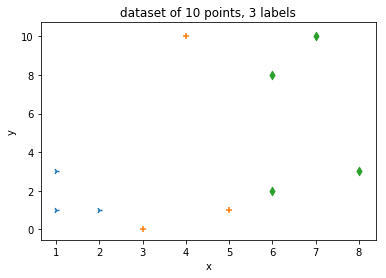

In [37]:
plot2DSet(training_set, "dataset of 10 points, 3 labels")

In [38]:
def display_discretization(labeled_set, threshold, a_j, title):
    '''
        labeled_set : labeled_set
        threshold : value of threshold 
        a_j : index of discretized attribute
        title : plot title
        
        display 2D database along with threshold generated by discretization on attribute a_j
    '''
    plot2DSet(labeled_set, title)
    
    if (a_j == 0):
        max_v = ceil(max(labeled_set.x[:,1]))
        min_v = floor(min(labeled_set.x[:,1]))
        plt.plot([threshold, threshold], [min_v, max_v])
    else:
        max_v = ceil(max(labeled_set.x[:,0]))
        min_v = floor(min(labeled_set.x[:,0]))
        plt.plot([min_v, max_v], [threshold, threshold])

    plt.show() 

In [111]:
def display_discretizations_comparison(labeled_set, threshold1, threshold2, real_thresholds, a_j, title, l1, l2):
    '''
        labeled_set : labeled_set
        threshold1 : threshold generated by discretization on a_j with first measure
        threshold2 : threshold generated by discretization on a_j with second measure
        real_thresholds : list of real thresholds
        title : plot title
        l1 : label of threshold1 (discrimination measure name)
        l2 : label of threshold2 (discrimination measure name)
        plot thresholds generated by two different discrimination measures on attribute a_j of labeled_set
    '''
    plot2DSet(labeled_set, title)
    
    if (a_j == 0):
        max_v = ceil(max(labeled_set.x[:,1]))
        min_v = floor(min(labeled_set.x[:,1]))
        plt.plot([threshold1, threshold1], [min_v, max_v], color='green', label=l1)
        plt.plot([threshold2, threshold2], [min_v, max_v], color='red', label=l2)
        for i in range(len(real_thresholds)):
            threshold = real_thresholds[i]
            if i == 0:
                plt.plot([threshold, threshold], [min_v, max_v], color='black', label="real threshold")
            else:
                plt.plot([threshold, threshold], [min_v, max_v], color='black')
    else:
        max_v = ceil(max(labeled_set.x[:,0]))
        min_v = floor(min(labeled_set.x[:,0]))
        plt.plot([min_v, max_v], [threshold1, threshold1], color='green', label=l1)
        plt.plot([min_v, max_v], [threshold2, threshold2], color='red', label=l2)
        for i in range(len(real_thresholds)):
            threshold = real_thresholds[i]
            if i == 0:
                plt.plot([min_v, max_v], [threshold, threshold], color='black', label="real threshold")
            else:
                plt.plot([min_v, max_v], [threshold, threshold], color='black')
    plt.legend()
    plt.show() 

In [66]:
def discretize_steps(H, labeled_set, a_j):
    '''
        a_j : index of attribute in labeled_set
        H : discrimation measure
        labeled_set : labeled set
        return each thresholds and entropy values computed by discretization of attribute a_j using H
    '''
    
    n = labeled_set.size()
    ind = np.argsort(labeled_set.x,axis=0)[:,a_j] # sort values 
    
    binary_set = LabeledSet(labeled_set.getInputDimension())
    binary_set.nb_examples = labeled_set.size()
    binary_set.x = labeled_set.x.copy()
    binary_set.x[:,a_j] = np.ones(labeled_set.size())
    binary_set.y = labeled_set.y
    
    thresholds = []
    H_values = []
    
    for i in range(n-1):
        current = labeled_set.getX(ind[i])[a_j]
        lookahead = labeled_set.getX(ind[i+1])[a_j]
        binary_set.x[ind[i]][a_j] = 0
        
        if current == lookahead:
            continue

        thresholds.append((current + lookahead) / 2.0)
        H_values.append(H.value(binary_set, a_j))
        
    return thresholds, H_values


splitting value generated by rsdm on axis 0 :  5.5
corresponding entropy :  0.1543719518489275
splitting value generated by sdm on axis 0 :  5.5
corresponding entropy :  0.6000000000000001


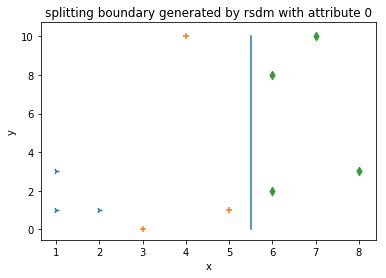

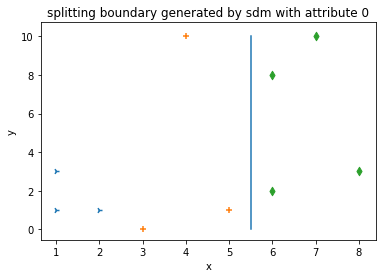

In [41]:
# rsdm 
f = Dsr()
g = Log()
h = Sum()

rsdm = Gdm(h, g, f)

# sdm
f = Ds()
g = Log()
h = Sum()

sdm = Gdm(h, g, f)

threshold_r, entropy_r = discretize(rsdm, training_set, 0)
print("splitting value generated by rsdm on axis 0 : ", threshold_r)
print("corresponding entropy : ", entropy_r)

threshold_nr, entropy_nr = discretize(sdm, training_set, 0)
print("splitting value generated by sdm on axis 0 : ", threshold_nr)
print("corresponding entropy : ", entropy_nr)

display_discretization(training_set, threshold_r, 0, "splitting boundary generated by rsdm with attribute 0")
display_discretization(training_set, threshold_nr, 0, "splitting boundary generated by sdm with attribute 0")

splitting value generated by rsdm on axis 1 :  1.5
corresponding entropy :  0.36320307543779357
splitting value generated by sdm on axis 1 :  1.5
corresponding entropy :  1.1509775004326936


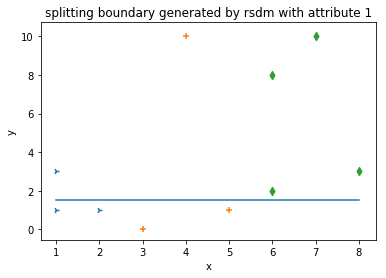

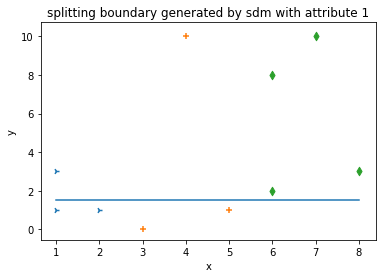

In [43]:
threshold_r, entropy_r = discretize(rsdm, training_set, 1)
print("splitting value generated by rsdm on axis 1 : ", threshold_r)
print("corresponding entropy : ", entropy_r)

threshold_nr, entropy_nr = discretize(sdm, training_set, 1)
print("splitting value generated by sdm on axis 1 : ", threshold_nr)
print("corresponding entropy : ", entropy_nr)

display_discretization(training_set, threshold_r, 1, "splitting boundary generated by rsdm with attribute 1")
display_discretization(training_set, threshold_nr, 1, "splitting boundary generated by sdm with attribute 1")

### Expérimentation sur des bases de données à deux dimensions

In [45]:
def generate_2Ddataset(a_j, k, n, noise, amplitude, ranges):
    '''
        a_j : monotone attribute
        k : number of labels
        n : number of examples to create 
        noise :  % of non-monotone noise
        amplitude : amplitude of noise
        ranges : array of arrays indicating, for each attribute, its min and max values
        return 2D dataset containing k classes and n examples, with a_j being the monotone attribute
    '''
    labeled_set = LabeledSet(2)
    p = round(n/k)
    r = n # remaining examples to add 
    
    current_min = ranges[a_j][0]
    total_range = ranges[a_j][1] - ranges[a_j][0]
    
    thresholds = []
    
    for q in range(k):
        current_max = current_min + (total_range / k) 

        if (current_max > ranges[a_j][1]):
            current_max = ranges[a_j][1]
        
        if (current_max < ranges[a_j][1] and q == k-1):
            current_max = ranges[a_j][1] 
        
        
        if (p < r) and (q==k-1):
            p = r

        
        monotone_values = np.random.uniform(current_min, current_max, size=(p,1))
        
        if noise > 0:
            sample_size = np.random.binomial(len(monotone_values), noise)
            sample = np.random.randint(0, len(monotone_values), size=sample_size)
            
            for e in sample:
                if random.random() < 0.5:
                    val = current_min - random.uniform(0, total_range * amplitude)
                    if (val < ranges[a_j][0]):
                        val = ranges[a_j][0]
                    monotone_values[e] = val
                else:
                    val = current_max + random.uniform(0, total_range * amplitude)
                    if (val > ranges[a_j][1]):
                        val = ranges[a_j][1]
                    monotone_values[e] = val
        
        thresholds.append((current_min,current_max) )
        
        if (a_j == 0):
            random_values = np.random.uniform(ranges[1][0], ranges[1][1], size=(p, 1))
            values = np.hstack((monotone_values, random_values))
        else:
            random_values = np.random.uniform(ranges[0][0], ranges[0][1], size=(p,1))
            values = np.hstack((random_values, monotone_values))
        
        for i in range(p):
            labeled_set.addExample(values[i], q+1)
            
        current_min = current_max
        r -= p 
    return labeled_set, thresholds

In [46]:
f = Dsr()
rsdm = Gdm(h, g, f)

f = Ds()
sdm = Gdm(h, g, f)

### 2 classes : 

#### Discrétisation de l'attribut monotone 

- ####  Étude de la différence entre les seuils obtenus par les deux mesures de discrimination

splitting value generated by rsdm on axis 0 :  0.04415079636096053
splitting value generated by sdm on axis 0 :  0.04415079636096053


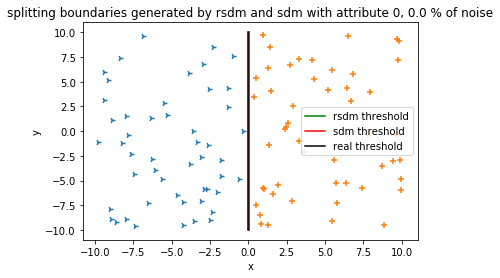

splitting value generated by rsdm on axis 0 :  0.31181910956723846
splitting value generated by sdm on axis 0 :  0.31181910956723846


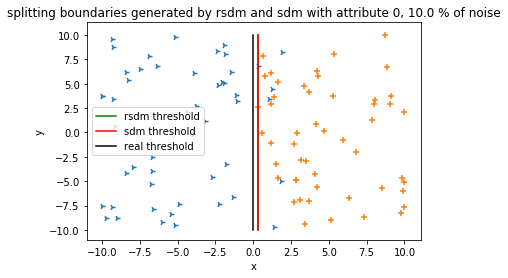

splitting value generated by rsdm on axis 0 :  1.5630310654757216
splitting value generated by sdm on axis 0 :  1.9896257653731884


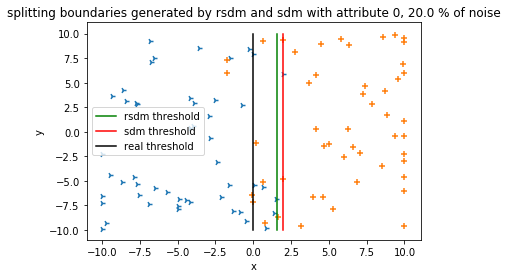

splitting value generated by rsdm on axis 0 :  1.5348447699166248
splitting value generated by sdm on axis 0 :  1.5348447699166248


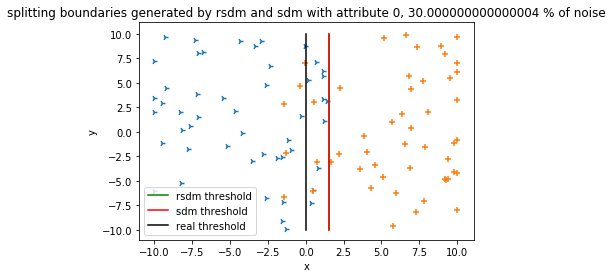

splitting value generated by rsdm on axis 0 :  -2.0293838541417597
splitting value generated by sdm on axis 0 :  -2.0293838541417597


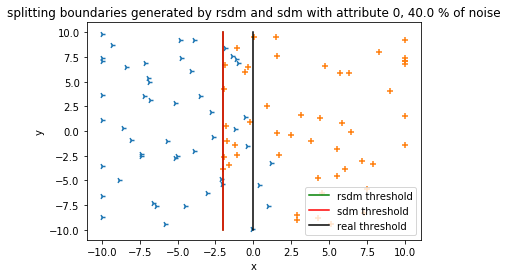

splitting value generated by rsdm on axis 0 :  -1.3391799207395778
splitting value generated by sdm on axis 0 :  -1.3391799207395778


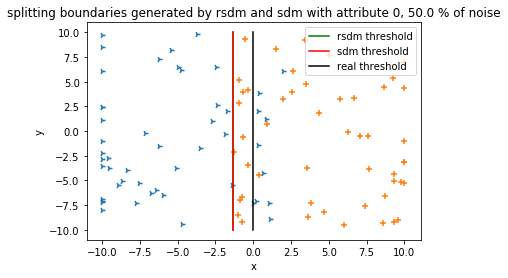

splitting value generated by rsdm on axis 0 :  1.3753907384779973
splitting value generated by sdm on axis 0 :  -1.8503095254364197


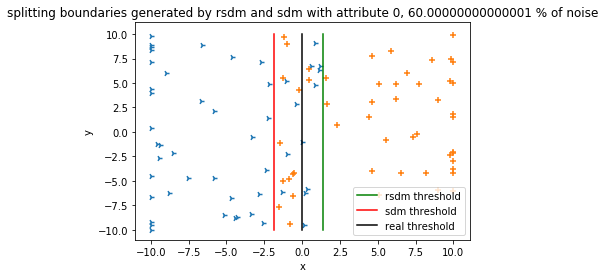

splitting value generated by rsdm on axis 0 :  -1.8484464220115195
splitting value generated by sdm on axis 0 :  -1.9627650558267882


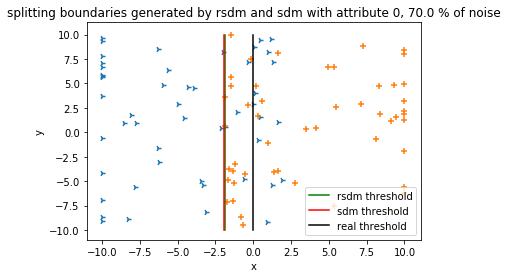

splitting value generated by rsdm on axis 0 :  1.9880395007252416
splitting value generated by sdm on axis 0 :  -2.0556222460701807


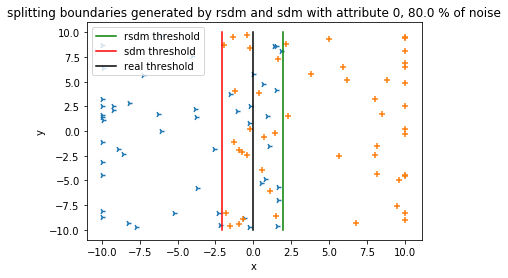

splitting value generated by rsdm on axis 0 :  1.9115277289891999
splitting value generated by sdm on axis 0 :  1.9115277289891999


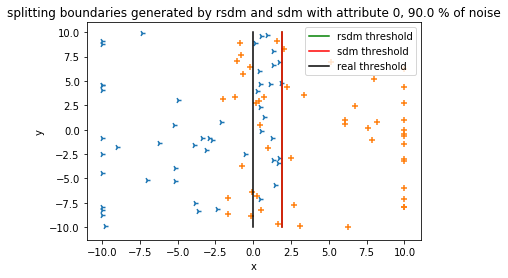

total run time : 103.86279702186584 s


In [92]:
avg_diff = []
std_diff = []

noises = np.arange(0., 1., 0.1)

threshold = 0

start = time.time()

for i in noises:
    thresholds_diff = []
    thresholds1 = []
    thresholds2 = []
    datasets = []
    
    for j in range(50):
        data_set, t = generate_2Ddataset(0, 2, 100, i, 0.1, [[-10, 10], [-10, 10]])
        datasets.append(data_set)
        
        threshold_r, entropy_r = discretize(rsdm, data_set, 0)
        thresholds1.append(threshold_r)

        threshold_nr, entropy_nr = discretize(sdm, data_set, 0)
        thresholds2.append(threshold_nr)

        thresholds_diff.append(fabs(threshold_nr - threshold_r))
    
    r = random.choice(np.arange(0, 10)) # for displaying
    data_set = datasets[r]
    threshold_r = thresholds1[r]
    threshold_nr = thresholds2[r]
        
    print("splitting value generated by rsdm on axis 0 : ", threshold_r)
    print("splitting value generated by sdm on axis 0 : ", threshold_nr)
    
    avg_diff.append(np.average(thresholds_diff))
    std_diff.append(np.std(thresholds_diff))
    
    display_discretizations_comparison(data_set, threshold_r, threshold_nr, [threshold], 0, "splitting boundaries generated by rsdm and sdm with attribute 0, " + str(i*100) + " % of noise", "rsdm threshold", "sdm threshold")

stop = time.time()
print("total run time : " + str(stop - start) + " s") 

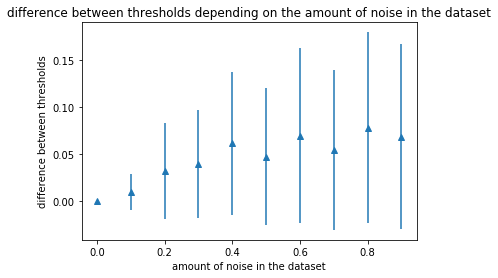

In [93]:
avg_diff_norm = np.array(avg_diff) / 20
std_diff_norm = np.array(std_diff) / 20


x = noises
y = avg_diff_norm
e = std_diff_norm

plt.errorbar(x, y, e, linestyle='None', marker='^')
plt.xlabel("amount of noise in the dataset")
plt.ylabel("difference between thresholds")
plt.title("difference between thresholds depending on the amount of noise in the dataset")
plt.show()

- #### Étude de la différence entre le vrai seuil de coupure et les seuils obtenus par chaque mesure de discrimination

In [94]:
noises = np.arange(0., 0.5, 0.05)

threshold = 0

avg_diff_1 = []
avg_diff_2 = []
std_diff_1 = []
std_diff_2 = []

start = time.time()

for i in noises:
    threshold_diff1 = []
    threshold_diff2 = []

    datasets = []
    
    for j in range(50):
        data_set, t = generate_2Ddataset(0, 2, 100, i, 0.1, [[-10, 10], [-10, 10]])
        datasets.append(data_set)
        
        threshold_r, entropy_r = discretize(rsdm, data_set, 0)
        threshold_diff1.append(fabs(threshold_r - threshold))

        threshold_nr, entropy_nr = discretize(sdm, data_set, 0)
        threshold_diff2.append(fabs(threshold_nr - threshold))
    
    avg_diff_1.append(np.average(threshold_diff1))
    std_diff_1.append(np.std(threshold_diff1))
    
    avg_diff_2.append(np.average(threshold_diff2))
    std_diff_2.append(np.std(threshold_diff2))

stop = time.time()
print("total run time : " + str(stop - start) + " s") 

total run time : 88.92425918579102 s


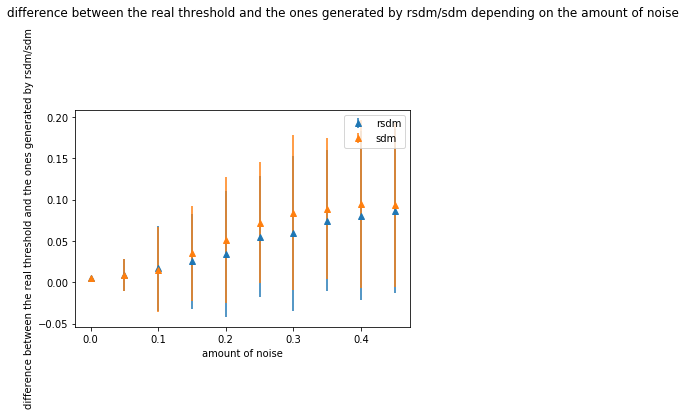

In [95]:
avg_diff_1_norm = np.array(avg_diff_1) / 20
std_diff_1_norm = np.array(std_diff_1) / 20

avg_diff_2_norm = np.array(avg_diff_2) / 20
std_diff_2_norm = np.array(std_diff_2) / 20

x1 = noises
y1 = avg_diff_1_norm
e1 = std_diff_1_norm

x2 = noises
y2 = avg_diff_2_norm
e2 = std_diff_2_norm

plt.errorbar(x1, y1, e, linestyle='None', marker='^', label='rsdm')
plt.errorbar(x2, y2, e, linestyle='None', marker='^', label='sdm')
plt.xlabel("amount of noise")
plt.ylabel("difference between the real threshold and the ones generated by rsdm/sdm")
plt.title("difference between the real threshold and the ones generated by rsdm/sdm depending on the amount of noise", x=0.8, y=1.4)
plt.legend()
plt.show()

- #### Étude de la valeur d'entropie en fonction du seuil de coupure

In [96]:
a_set, t = generate_2Ddataset(0, 2, 100, 0.4, 0.1, [[-10, 10], [-10, 10]])

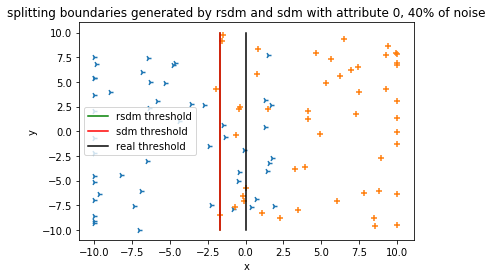

In [97]:
t1, h1 = discretize(rsdm, data_set, 0)
t2, h2 = discretize(sdm, data_set, 0)
display_discretizations_comparison(a_set, t1, t2, [0], 0, "splitting boundaries generated by rsdm and sdm with attribute 0, 40% of noise", "rsdm threshold", "sdm threshold")

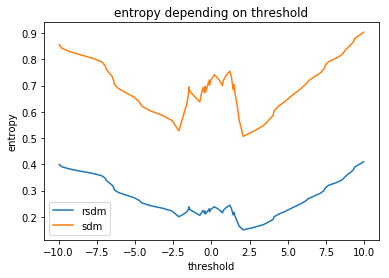

In [98]:
x, y1 = discretize_steps(rsdm, a_set, 0)
x, y2 = discretize_steps(sdm, a_set, 0)
plt.plot(x, y1, label="rsdm")
plt.plot(x, y2, label="sdm")
plt.xlabel("threshold")
plt.ylabel("entropy")
plt.title("entropy depending on threshold")
plt.legend()
plt.show()

#### Discrétisation de l'attribut non monotone 

- ####  Étude de la différence entre les seuils obtenus par les deux mesures de discrimination

splitting value generated by rsdm on axis 1 :  -5.769026465217831
splitting value generated by sdm on axis 1 :  9.216673482379491


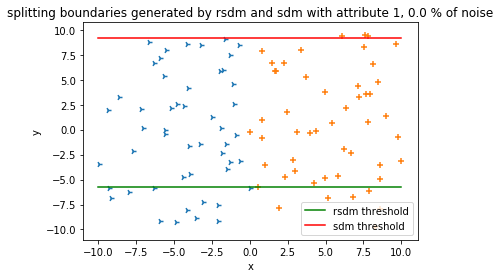

splitting value generated by rsdm on axis 1 :  2.840815228907953
splitting value generated by sdm on axis 1 :  -1.7301797187811667


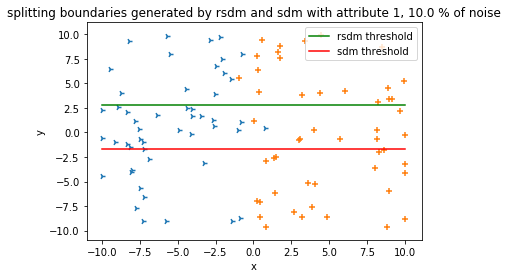

splitting value generated by rsdm on axis 1 :  8.677469160876859
splitting value generated by sdm on axis 1 :  2.9277090832130384


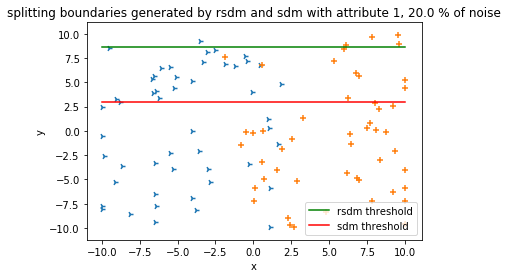

splitting value generated by rsdm on axis 1 :  7.24637366594281
splitting value generated by sdm on axis 1 :  9.778195772653302


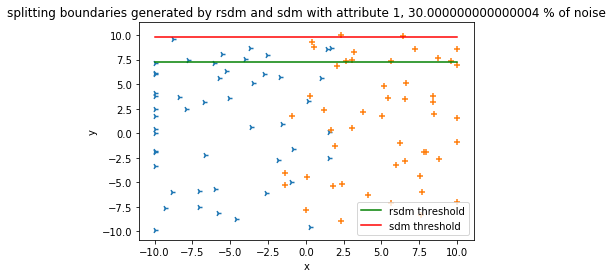

splitting value generated by rsdm on axis 1 :  -8.751945829458819
splitting value generated by sdm on axis 1 :  -8.751945829458819


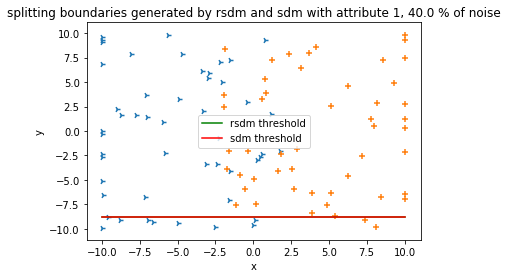

splitting value generated by rsdm on axis 1 :  9.813926703423705
splitting value generated by sdm on axis 1 :  -5.640686989908259


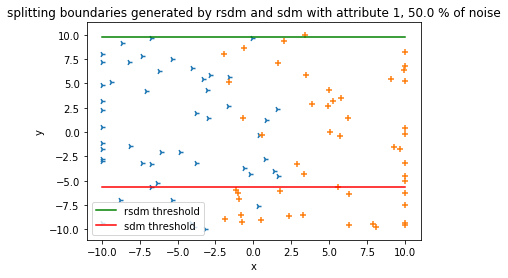

splitting value generated by rsdm on axis 1 :  -1.2559030154629491
splitting value generated by sdm on axis 1 :  -9.084306582213546


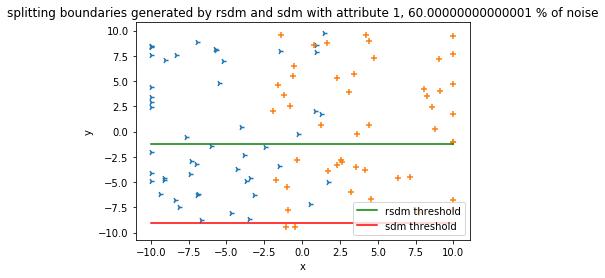

splitting value generated by rsdm on axis 1 :  1.7655462039872578
splitting value generated by sdm on axis 1 :  1.7655462039872578


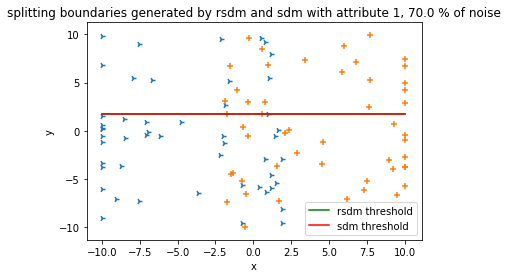

splitting value generated by rsdm on axis 1 :  -4.668922061891479
splitting value generated by sdm on axis 1 :  -8.607579709098422


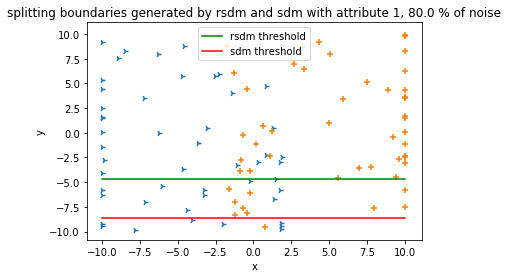

splitting value generated by rsdm on axis 1 :  8.036191375039474
splitting value generated by sdm on axis 1 :  -8.594299628770678


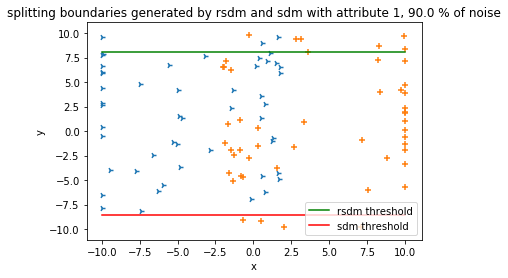

run time : -1528595827.3325012 s


In [99]:
avg_diff = []
std_diff = []

noises = np.arange(0., 1., 0.1)

start = time.time()

for i in noises:
    thresholds_diff = []
    thresholds1 = []
    thresholds2 = []
    datasets = []
    
    for j in range(50):
        data_set, t = generate_2Ddataset(0, 2, 100, i, 0.1, [[-10, 10], [-10, 10]])
        datasets.append(data_set)
        
        threshold_r, entropy_r = discretize(rsdm, data_set, 1)
        thresholds1.append(threshold_r)

        threshold_nr, entropy_nr = discretize(sdm, data_set, 1)
        thresholds2.append(threshold_nr)

        thresholds_diff.append(fabs(threshold_nr - threshold_r))
    
    r = random.choice(np.arange(0, 10))
    data_set = datasets[r]
    threshold_r = thresholds1[r]
    threshold_nr = thresholds2[r]
    
    print("splitting value generated by rsdm on axis 1 : ", threshold_r)
    print("splitting value generated by sdm on axis 1 : ", threshold_nr)
    
    avg_diff.append(np.average(thresholds_diff))
    std_diff.append(np.std(thresholds_diff))
    
    display_discretizations_comparison(data_set, threshold_r, threshold_nr, [], 1, "splitting boundaries generated by rsdm and sdm with attribute 1, " + str(i*100) + " % of noise", "rsdm threshold", "sdm threshold")

stop = time.time()
print("run time : " + str(stop - start) + " s")

In [100]:
avg_diff_norm = np.array(avg_diff) / 20
std_diff_norm = np.array(std_diff) / 20

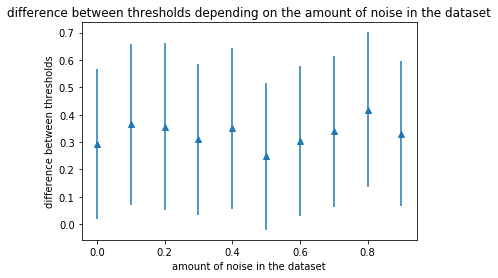

In [101]:
x = noises
y = avg_diff_norm
e = std_diff_norm

plt.errorbar(x, y, e, linestyle='None', marker='^')
plt.xlabel("amount of noise in the dataset")
plt.ylabel("difference between thresholds")
plt.title("difference between thresholds depending on the amount of noise in the dataset")
plt.show()

- #### Étude de la valeur d'entropie en fonction du seuil de coupure

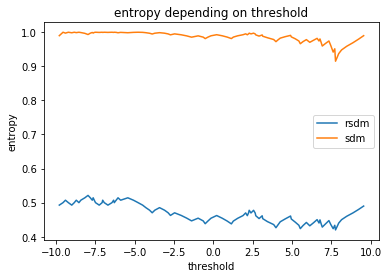

In [102]:
x, y1 = discretize_steps(rsdm, a_set, 1)
x, y2 = discretize_steps(sdm, a_set, 1)
plt.plot(x, y1, label="rsdm")
plt.plot(x, y2, label="sdm")
plt.xlabel("threshold")
plt.ylabel("entropy")
plt.title("entropy depending on threshold")
plt.legend()
plt.show()

### 3 classes

thresholds :  [(-10, -3.333333333333333), (-3.333333333333333, 3.333333333333334), (3.333333333333334, 10.0)]


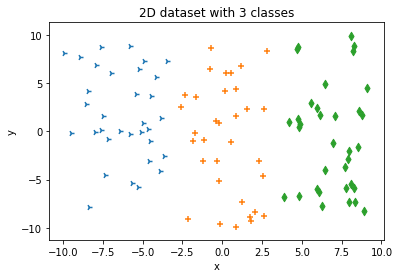

In [103]:
set3, t = generate_2Ddataset(0, 3, 100, 0, 0.1, [[-10, 10], [-10, 10]])
plot2DSet(set3, "2D dataset with 3 classes")
print("thresholds : ", t)

In [104]:
thr1 = t[0][1]
thr2 = t[2][0]

#### Discrétisation de l'attribut monotone 

- ####  Étude de la différence entre les seuils obtenus par les deux mesures de discrimination

splitting value generated by rsdm on axis 0 :  3.549753134073269
splitting value generated by sdm on axis 0 :  3.549753134073269


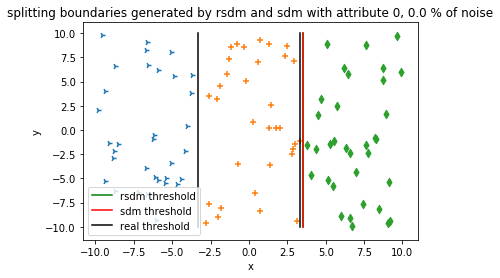

splitting value generated by rsdm on axis 0 :  3.312890739458421
splitting value generated by sdm on axis 0 :  3.312890739458421


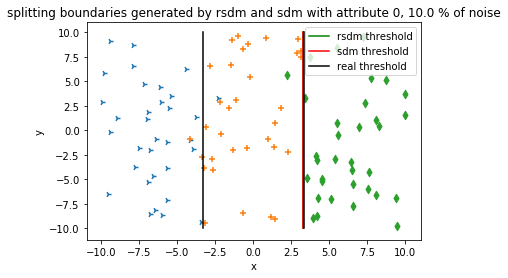

splitting value generated by rsdm on axis 0 :  0.8710785057762201
splitting value generated by sdm on axis 0 :  0.8710785057762201


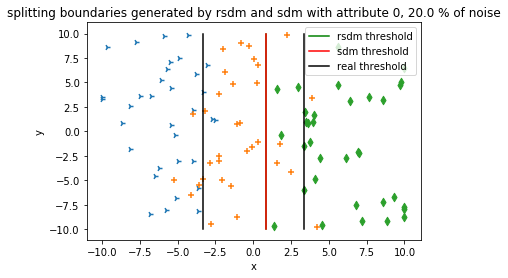

splitting value generated by rsdm on axis 0 :  1.6343119223812064
splitting value generated by sdm on axis 0 :  1.6343119223812064


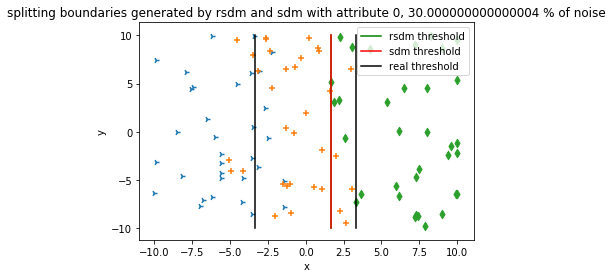

splitting value generated by rsdm on axis 0 :  1.9512206403273806
splitting value generated by sdm on axis 0 :  -1.8002790054032598


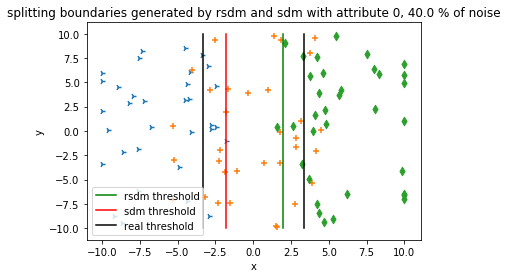

splitting value generated by rsdm on axis 0 :  1.3491231423314578
splitting value generated by sdm on axis 0 :  -1.354689232042415


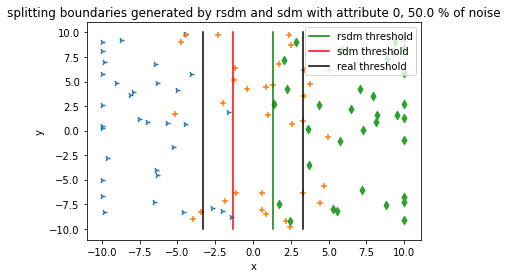

splitting value generated by rsdm on axis 0 :  2.0044453215498907
splitting value generated by sdm on axis 0 :  0.7129380563408481


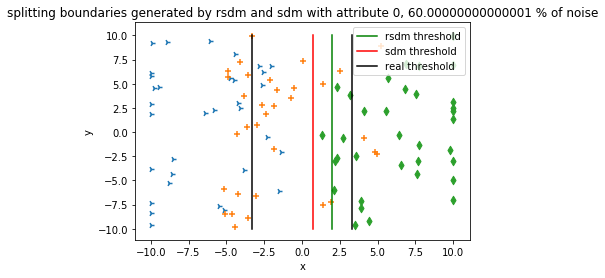

splitting value generated by rsdm on axis 0 :  1.1039138910788457
splitting value generated by sdm on axis 0 :  1.1039138910788457


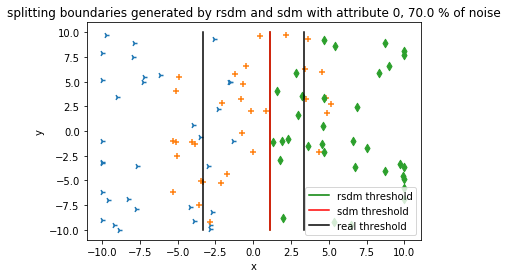

splitting value generated by rsdm on axis 0 :  0.8909174035154437
splitting value generated by sdm on axis 0 :  -1.0805214681888908


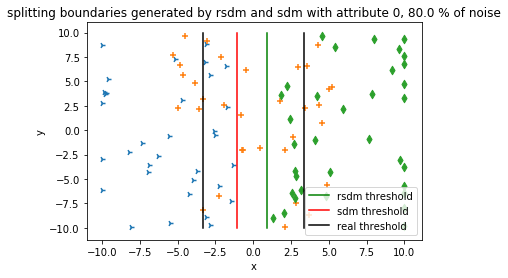

splitting value generated by rsdm on axis 0 :  1.6182129564573589
splitting value generated by sdm on axis 0 :  1.6182129564573589


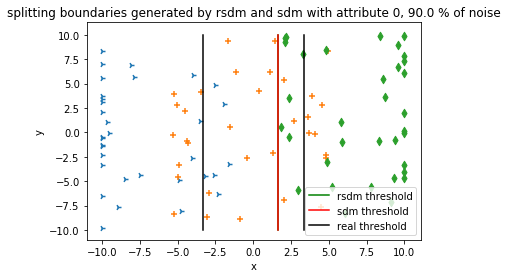

total run time : 138.16330099105835 s


In [112]:
avg_diff = []
std_diff = []

noises = np.arange(0., 1., 0.1)

start = time.time()
for i in noises:
    thresholds_diff = []
    thresholds1 = []
    thresholds2 = []
    datasets = []
    
    for j in range(50):
        data_set, t = generate_2Ddataset(0, 3, 100, i, 0.1, [[-10, 10], [-10, 10]])
        datasets.append(data_set)
        
        threshold_r, entropy_r = discretize(rsdm, data_set, 0)
        thresholds1.append(threshold_r)

        threshold_nr, entropy_nr = discretize(sdm, data_set, 0)
        thresholds2.append(threshold_nr)

        thresholds_diff.append(fabs(threshold_nr - threshold_r))
    
    r = random.choice(np.arange(0, 10))
    data_set = datasets[r]
    threshold_r = thresholds1[r]
    threshold_nr = thresholds2[r]
        
    print("splitting value generated by rsdm on axis 0 : ", threshold_r)
    print("splitting value generated by sdm on axis 0 : ", threshold_nr)
    
    avg_diff.append(np.average(thresholds_diff))
    std_diff.append(np.std(thresholds_diff))
    
    display_discretizations_comparison(data_set, threshold_r, threshold_nr, [thr1, thr2], 0, "splitting boundaries generated by rsdm and sdm with attribute 0, " + str(i*100) + " % of noise", "rsdm threshold", "sdm threshold")

stop = time.time()
print("total run time : " + str(stop - start) + " s")  

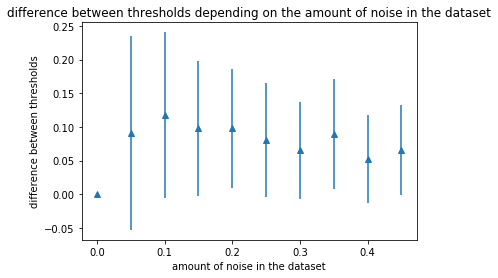

In [116]:
avg_diff_norm = np.array(avg_diff) / 20
std_diff_norm = np.array(std_diff) / 20

x = noises
y = avg_diff_norm
e = std_diff_norm

plt.errorbar(x, y, e, linestyle='None', marker='^')
plt.xlabel("amount of noise in the dataset")
plt.ylabel("difference between thresholds")
plt.title("difference between thresholds depending on the amount of noise in the dataset")
plt.show()

- #### Étude de la différence entre le vrai seuil de coupure et les seuils obtenus par chaque mesure de discrimination

In [117]:
noises = np.arange(0., 0.5, 0.05)

# difference between rsdm threshold and first threshold
avg_diff_1_1 = []
std_diff_1_1 = []

# difference between rsdm threshold and second threshold
avg_diff_1_2 = []
std_diff_1_2 = []

# difference between sdm threshold and first threshold
avg_diff_2_1 = []
std_diff_2_1 = []

# difference between sdm threshold and second threshold
avg_diff_2_2 = []
std_diff_2_2 = []

start = time.time()

for i in noises:
    threshold_diff1_1 = []
    threshold_diff1_2 = []
    threshold_diff2_1 = []
    threshold_diff2_2 = []
    
    datasets = []
    
    for j in range(50):
        data_set, t = generate_2Ddataset(0, 2, 100, i, 0.1, [[-10, 10], [-10, 10]])
        datasets.append(data_set)
        
        threshold_r, entropy_r = discretize(rsdm, data_set, 0)
        
        threshold_diff1_1.append(fabs(threshold_r - thr1))
        threshold_diff1_2.append(fabs(threshold_r - thr2))

        threshold_nr, entropy_nr = discretize(sdm, data_set, 0)
        
        threshold_diff2_1.append(fabs(threshold_nr - thr1))
        threshold_diff2_2.append(fabs(threshold_nr - thr2))
    
    avg_diff_1_1.append(np.average(threshold_diff1_1))
    avg_diff_1_2.append(np.average(threshold_diff1_2))
    std_diff_1_1.append(np.std(threshold_diff1_1))
    std_diff_1_2.append(np.std(threshold_diff1_2))
    
    avg_diff_2_1.append(np.average(threshold_diff2_1))
    avg_diff_2_2.append(np.average(threshold_diff2_2))
    std_diff_2_1.append(np.std(threshold_diff2_1))
    std_diff_2_2.append(np.std(threshold_diff2_2))

stop = time.time()
print("total run time : " + str(stop - start) + " s") 

total run time : 86.2765600681305 s


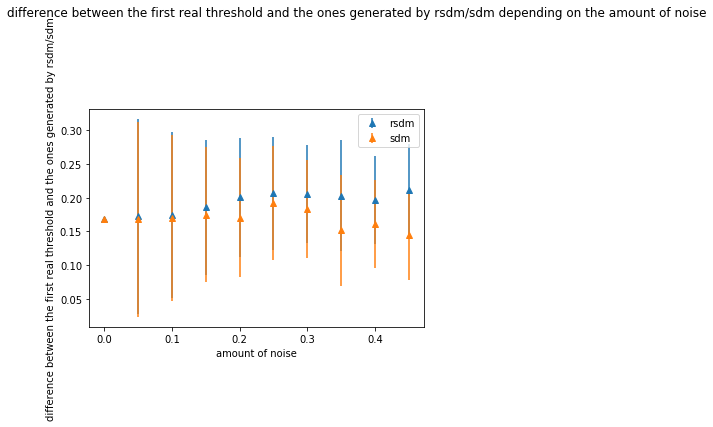

In [119]:
avg_diff_1_1_norm = np.array(avg_diff_1_1) / 20
std_diff_1_1_norm = np.array(std_diff_1_1) / 20

avg_diff_2_1_norm = np.array(avg_diff_2_1) / 20
std_diff_2_1_norm = np.array(std_diff_2_1) / 20

x1 = noises
y1 = avg_diff_1_1_norm
e1 = std_diff_1_1_norm

x2 = noises
y2 = avg_diff_2_1_norm
e2 = std_diff_2_1_norm

plt.errorbar(x1, y1, e, linestyle='None', marker='^', label='rsdm')
plt.errorbar(x2, y2, e, linestyle='None', marker='^', label='sdm')
plt.xlabel("amount of noise")
plt.ylabel("difference between the first real threshold and the ones generated by rsdm/sdm")
plt.title("difference between the first real threshold and the ones generated by rsdm/sdm depending on the amount of noise", x=0.8, y=1.4)
plt.legend()
plt.show()

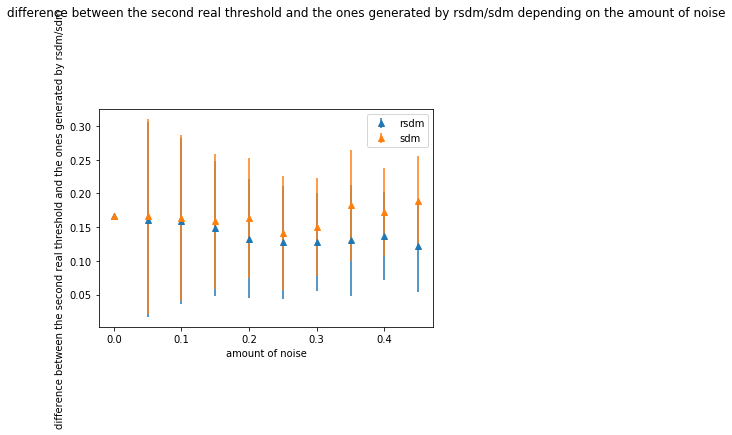

In [121]:
avg_diff_1_2_norm = np.array(avg_diff_1_2) / 20
std_diff_1_2_norm = np.array(std_diff_1_2) / 20

avg_diff_2_2_norm = np.array(avg_diff_2_2) / 20
std_diff_2_2_norm = np.array(std_diff_2_2) / 20

x1 = noises
y1 = avg_diff_1_2_norm
e1 = std_diff_1_2_norm

x2 = noises
y2 = avg_diff_2_2_norm
e2 = std_diff_2_2_norm

plt.errorbar(x1, y1, e, linestyle='None', marker='^', label='rsdm')
plt.errorbar(x2, y2, e, linestyle='None', marker='^', label='sdm')
plt.xlabel("amount of noise")
plt.ylabel("difference between the second real threshold and the ones generated by rsdm/sdm")
plt.title("difference between the second real threshold and the ones generated by rsdm/sdm depending on the amount of noise", x=0.8, y=1.4)
plt.legend()
plt.show()

- #### Étude de la valeur d'entropie en fonction du seuil de coupure

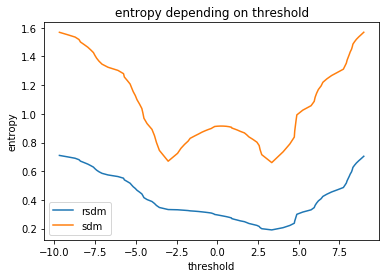

In [122]:
x, y1 = discretize_steps(rsdm, set3, 0)
x, y2 = discretize_steps(sdm, set3, 0)
plt.plot(x, y1, label="rsdm")
plt.plot(x, y2, label="sdm")
plt.xlabel("threshold")
plt.ylabel("entropy")
plt.title("entropy depending on threshold")
plt.legend()
plt.show()

#### Discrétisation de l'attribut non monotone 

- ####  Étude de la différence entre les seuils obtenus par les deux mesures de discrimination

splitting value generated by rsdm on axis 0 :  9.23274776582825
splitting value generated by sdm on axis 0 :  -8.567828017111351


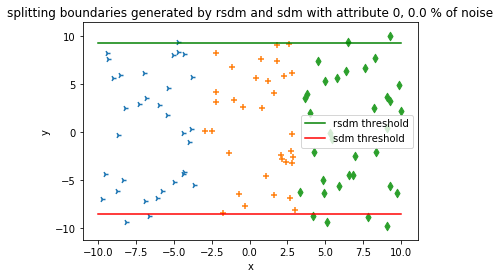

splitting value generated by rsdm on axis 0 :  3.0365502688821673
splitting value generated by sdm on axis 0 :  -3.5916154923069565


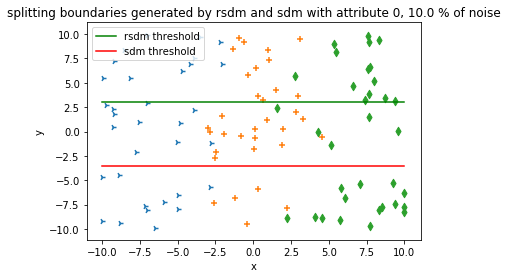

splitting value generated by rsdm on axis 0 :  -9.048732586856788
splitting value generated by sdm on axis 0 :  -9.846479539866518


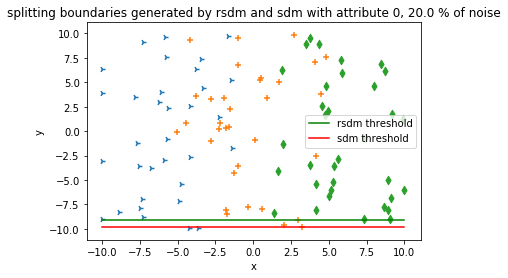

splitting value generated by rsdm on axis 0 :  6.760222439324108
splitting value generated by sdm on axis 0 :  8.378773002015711


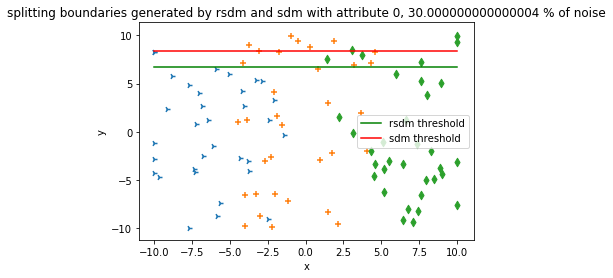

splitting value generated by rsdm on axis 0 :  8.97857906954535
splitting value generated by sdm on axis 0 :  8.97857906954535


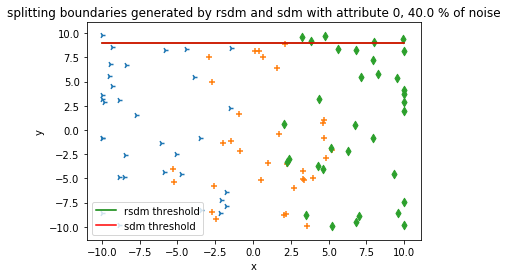

splitting value generated by rsdm on axis 0 :  9.187031012536474
splitting value generated by sdm on axis 0 :  7.604477169926422


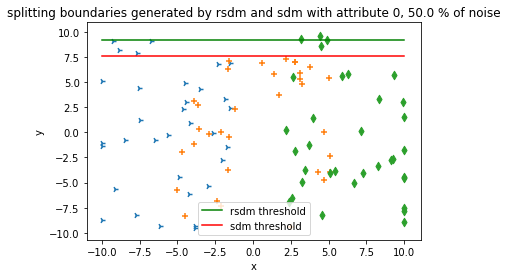

splitting value generated by rsdm on axis 0 :  1.7527919239219507
splitting value generated by sdm on axis 0 :  1.7527919239219507


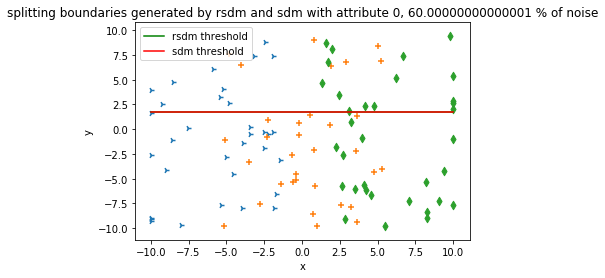

splitting value generated by rsdm on axis 0 :  -2.3054194313429908
splitting value generated by sdm on axis 0 :  -8.002540452915966


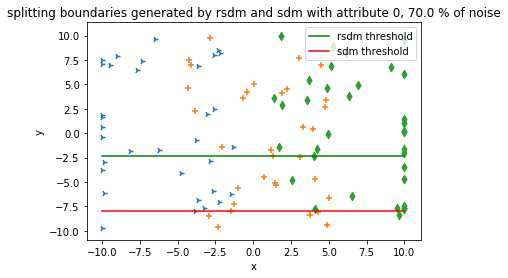

splitting value generated by rsdm on axis 0 :  7.364819254273517
splitting value generated by sdm on axis 0 :  6.980897046809275


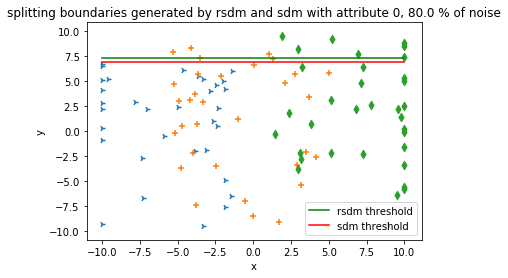

splitting value generated by rsdm on axis 0 :  -3.741939924391534
splitting value generated by sdm on axis 0 :  9.37923902346504


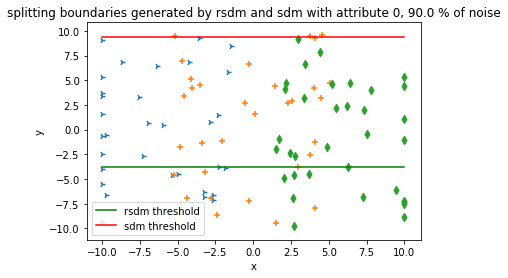

total run time : 433.7106771469116 s


In [124]:
avg_diff = []
std_diff = []

noises = np.arange(0., 1., 0.1)

start = time.time()
for i in noises:
    thresholds_diff = []
    thresholds1 = []
    thresholds2 = []
    datasets = []
    
    for j in range(50):
        data_set, t = generate_2Ddataset(0, 3, 100, i, 0.1, [[-10, 10], [-10, 10]])
        datasets.append(data_set)
        
        threshold_r, entropy_r = discretize(rsdm, data_set, 1)
        thresholds1.append(threshold_r)

        threshold_nr, entropy_nr = discretize(sdm, data_set, 1)
        thresholds2.append(threshold_nr)

        thresholds_diff.append(fabs(threshold_nr - threshold_r))
    
    r = random.choice(np.arange(0, 10))
    data_set = datasets[r]
    threshold_r = thresholds1[r]
    threshold_nr = thresholds2[r]
        
    print("splitting value generated by rsdm on axis 0 : ", threshold_r)
    print("splitting value generated by sdm on axis 0 : ", threshold_nr)
    
    avg_diff.append(np.average(thresholds_diff))
    std_diff.append(np.std(thresholds_diff))
    
    display_discretizations_comparison(data_set, threshold_r, threshold_nr, [], 1, "splitting boundaries generated by rsdm and sdm with attribute 0, " + str(i*100) + " % of noise", "rsdm threshold", "sdm threshold")

stop = time.time()
print("total run time : " + str(stop - start) + " s")  